In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

In [2]:
obsdf=pd.read_csv('observations.csv')
print(obsdf.dtypes)
obsdf.head()

scientific_name    object
park_name          object
observations        int64
dtype: object


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [3]:
speciesdf=pd.read_csv('species_info.csv')
print(speciesdf.dtypes)
speciesdf.head()

category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


Above we have given an initial view of our two datasets. The first datafram contains the number of observations of each species in each park, and the second contains info on each species. To start it would help for us to join these table (we will do a left join on the first dataframe)

In [4]:
biodf=pd.merge(obsdf,speciesdf,how='left')
print(biodf.dtypes)
biodf.head()

scientific_name        object
park_name              object
observations            int64
category               object
common_names           object
conservation_status    object
dtype: object


,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",NaN
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,NaN
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,NaN
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,NaN
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,NaN


We now have a complete dataframe with all the necessary info for analysis! Before we get started, we should do some EDA and look for null values to ensure our dataset is clean

In [5]:
maxRows = biodf['scientific_name'].count()
print('% Missing Data:')
print((1 - biodf.count() / maxRows) * 100)


% Missing Data:
scientific_name         0.000000
park_name               0.000000
observations            0.000000
category                0.000000
common_names            0.000000
conservation_status    96.566792
dtype: float64


That was lucky! We have no null values in any of our columns, exept for the conservation_status variable. With such a high percentage of null values this is likely to be structurally missing data, lets take a closer look!

In [6]:
print(biodf.conservation_status.isna().sum())
biodf.conservation_status.value_counts()

24752


Species of Concern    732
Endangered             80
Threatened             44
In Recovery            24
Name: conservation_status, dtype: int64

From this it's fairly obvious that this column only contains data if a species is almost endangered, enagered or in recovery. If the species is doing fine it will have a null value! It will be easier to work with the data if we assign a value ot these null values

In [7]:
biodf['conservation_status']=biodf.conservation_status.fillna('Fine')
biodf.conservation_status.value_counts()

Fine                  24752
Species of Concern      732
Endangered               80
Threatened               44
In Recovery              24
Name: conservation_status, dtype: int64

Rejoice! We have no null data, now we can focus strictly on our analysis!

First lets get an overview of the number of observations of each animal category by park

In [8]:
obsdf=biodf[['park_name','observations','category']]
#Lets see how many categories we have - 7
obsdf.category.value_counts()

Vascular Plant       19560
Bird                  2364
Nonvascular Plant     1332
Mammal                1200
Fish                   524
Amphibian              328
Reptile                324
Name: category, dtype: int64

In [9]:
obsdf=obsdf.groupby(['park_name','category']).observations.sum().reset_index()
obsdf.columns=['Park Name','Category','Observations']
obsdf['Park Name']=obsdf['Park Name'].str.strip('(?i)National Park')
obsdf.head()

,Park Name,Category,Observations
0,Bryce,Amphibian,7542
1,Bryce,Bird,58590
2,Bryce,Fish,12823
3,Bryce,Mammal,28830
4,Bryce,Nonvascular Plant,32992


In [10]:
obsdf.to_csv('NationalParkSpeciesObs.csv')

Now we'll be turning our analysis towards endangered species, first lets consider which parks see the most endangered species

In [11]:
ParkESdf=biodf[['park_name','observations','conservation_status']]
biodf.head()

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Fine
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Fine
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,Fine
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,Fine
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,Fine


In [12]:
parktotals=ParkESdf.groupby(['park_name']).observations.sum()
parktotals

park_name
Bryce National Park                     633291
Great Smoky Mountains National Park     474863
Yellowstone National Park              1587641
Yosemite National Park                  949452
Name: observations, dtype: int64

In [13]:
test=ParkESdf.groupby(['park_name','conservation_status']).observations.sum().reset_index()
test.columns=['park','conservation_status','observations']

In [14]:
test['weight (%)']= test.apply(lambda row: (row.observations/parktotals.loc[row.park])*100,axis=1)
test=test[test.conservation_status!='Fine']
test
    

,park,conservation_status,observations,weight (%)
0,Bryce National Park,Endangered,619,0.097743
2,Bryce National Park,In Recovery,388,0.061267
3,Bryce National Park,Species of Concern,17011,2.686127
4,Bryce National Park,Threatened,591,0.093322
5,Great Smoky Mountains National Park,Endangered,393,0.082761
7,Great Smoky Mountains National Park,In Recovery,248,0.052226
8,Great Smoky Mountains National Park,Species of Concern,11735,2.471239
9,Great Smoky Mountains National Park,Threatened,440,0.092658
10,Yellowstone National Park,Endangered,1558,0.098133
12,Yellowstone National Park,In Recovery,889,0.055995


Which categories have the most endangered species

In [15]:
biodf.head()

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Fine
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Fine
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,Fine
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,Fine
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,Fine


In [16]:
dangerdf=biodf[['category','conservation_status','observations']]
dangerdf.head()

,category,conservation_status,observations
0,Vascular Plant,Fine,68
1,Mammal,Fine,77
2,Vascular Plant,Fine,138
3,Vascular Plant,Fine,84
4,Vascular Plant,Fine,85


In [17]:
dangerdf=dangerdf.groupby(['category','conservation_status']).observations.sum().reset_index()
dangerdf=dangerdf[dangerdf.conservation_status=='Endangered']
dangerdf.head()


,category,conservation_status,observations
0,Amphibian,Endangered,144
4,Bird,Endangered,574
8,Fish,Endangered,455
12,Mammal,Endangered,2178
21,Vascular Plant,Endangered,162


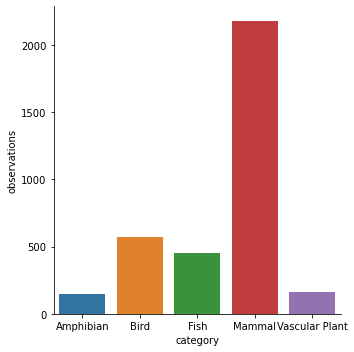

In [18]:
ax = sns.catplot(x='category',y='observations',data=dangerdf,kind='bar')

Mammals are much more likely to be endangered! Although we should consider the weighting!

In [21]:
wmdf=biodf.groupby('category').observations.sum()
dangerdf['% of type endangered']=dangerdf.apply(lambda row:row.observations/wmdf.loc[row.category],axis=1)
dangerdf.head()

,category,conservation_status,observations,% of type endangered
0,Amphibian,Endangered,144,0.003195
4,Bird,Endangered,574,0.001727
8,Fish,Endangered,455,0.006241
12,Mammal,Endangered,2178,0.013352
21,Vascular Plant,Endangered,162,0.000058
